In [1]:
print("""
@Title        : Data Preprocessing
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2023-12-09 23:18:23
@Description  : 
""")


@Title        : Data Preprocessing
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2023-12-09 23:18:23
@Description  : 



In [3]:
import pandas as pd
import numpy as np

## Converting prices to returns

In [70]:
df = pd.read_csv('../data/AAPL_20100101_20201231.csv', index_col='Date', parse_dates=['Date'])
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.478997,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490201,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386965,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375156,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417541,447610800
...,...,...,...,...,...,...
2020-12-23,132.160004,132.429993,130.779999,130.960007,128.687241,88223700
2020-12-24,131.320007,133.460007,131.100006,131.970001,129.679749,54930100
2020-12-28,133.990005,137.339996,133.509995,136.690002,134.317825,124486200


In [71]:
df = df[['Adj Close']].copy()
df['simple_rtn'] = df['Adj Close'].pct_change()
df['log_rtn'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

In [72]:
df.head()

,Adj Close,simple_rtn,log_rtn
Date,,,
2010-01-04,6.478997,NaN,NaN
2010-01-05,6.490201,0.001729,0.001728
2010-01-06,6.386965,-0.015906,-0.016034
2010-01-07,6.375156,-0.001849,-0.001851
2010-01-08,6.417541,0.006648,0.006626


In [73]:
df = df.resample('M').last()

## Adjusting the returns for inflation

In [74]:
# 不要用这个狗屎数据
df_cpi = pd.read_csv('../data/cpi_20100101_20230901.csv', index_col='date', parse_dates=['date'])
df_cpi.columns = ['cpi']

In [75]:
df_cpi.head()

,cpi
date,
2010-01-31,216.687
2010-02-28,216.741
2010-03-31,217.631
2010-04-30,218.009
2010-05-31,218.178


In [80]:
df = pd.read_csv('../data/AAPL_20100101_20201231.csv', index_col='Date', parse_dates=['Date'])
df = df[['Adj Close']].copy()
df = df.resample('M').last()
df.head()

,Adj Close
Date,
2010-01-31,5.814478
2010-02-28,6.194722
2010-03-31,7.114455
2010-04-30,7.904309
2010-05-31,7.776853


In [81]:
df = df.join(df_cpi, how='left')

In [82]:
df['simple_rtn'] = df['Adj Close'].pct_change()
df['inflation_rate'] = df['cpi'].pct_change()

In [83]:
df['real_rtn'] = (df['simple_rtn'] + 1) / (df['inflation_rate'] + 1) - 1
df.head()

,Adj Close,cpi,simple_rtn,inflation_rate,real_rtn
Date,,,,,
2010-01-31,5.814478,216.687,NaN,NaN,NaN
2010-02-28,6.194722,216.741,0.065396,0.000249,0.065131
2010-03-31,7.114455,217.631,0.148470,0.004106,0.143774
2010-04-30,7.904309,218.009,0.111021,0.001737,0.109095
2010-05-31,7.776853,218.178,-0.016125,0.000775,-0.016887


## Changing the frequency of time series data

主要用于：
1. 收益率
2. 波动率（一年连续复利的方差）

In [110]:
df = pd.read_csv('../data/AAPL_20100101_20201231.csv', index_col='Date', parse_dates=['Date'])
df = df[['Adj Close']].copy()
df['log_rtn'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
df = df.dropna(axis=0).drop('Adj Close', axis=1)
df.head()

,log_rtn
Date,
2010-01-05,0.001728
2010-01-06,-0.016034
2010-01-07,-0.001851
2010-01-08,0.006626
2010-01-11,-0.008860


In [111]:
def realized_volatility(x):
    return np.sqrt(np.sum(x ** 2, axis=0))

In [112]:
df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility).rename(columns={'log_rtn': 'rv'})

In [114]:
df_rv['rv'] = df_rv['rv'] * np.sqrt(12)

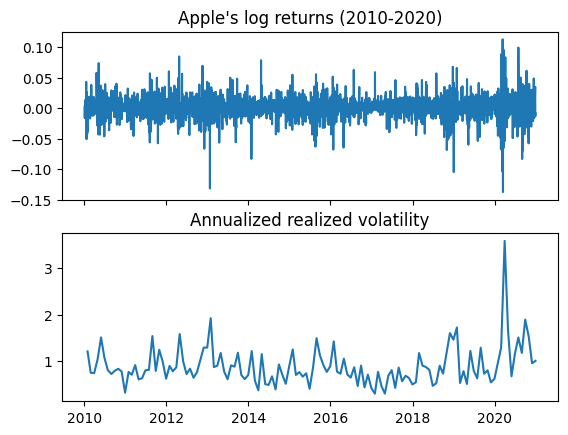

In [117]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df)
ax[1].plot(df_rv)
ax[0].set_title("Apple's log returns (2010-2020)")
ax[1].set_title("Annualized realized volatility")
plt.show()

## Different ways of imputing missing data

In [125]:
np.random.seed(42)
df = pd.read_csv('../data/cpi_20100101_20230901.csv', index_col='date', parse_dates=['date'])
df.head()

,cpi
date,
2010-01-31,216.687
2010-02-28,216.741
2010-03-31,217.631
2010-04-30,218.009
2010-05-31,218.178


In [126]:
rand_indices = np.random.choice(df.index, 5, replace=False)
rand_indices

array(['2021-04-30T00:00:00.000000000', '2019-08-31T00:00:00.000000000',
       '2020-12-31T00:00:00.000000000', '2014-08-31T00:00:00.000000000',
       '2017-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [127]:
df['cpi_missing'] = df.loc[:, 'cpi']
df.loc[rand_indices, 'cpi_missing'] = np.nan
df.head()

,cpi,cpi_missing
date,,
2010-01-31,216.687,216.687
2010-02-28,216.741,216.741
2010-03-31,217.631,217.631
2010-04-30,218.009,218.009
2010-05-31,218.178,218.178


In [139]:
for method in ['bfill', 'ffill']:
    # df[["cpi_missing"]].fillna(method=method)
    # 未来版本要被取消
    df[f'method_{method}'] = getattr(df[['cpi_missing']], method)()

In [140]:
df.loc[rand_indices, :]

,cpi,cpi_missing,method_bfill,method_ffill
date,,,,
2021-04-30,267.054,NaN,269.195,264.877
2019-08-31,256.558,NaN,256.759,256.571
2020-12-31,260.474,NaN,261.582,260.229
2014-08-31,237.852,NaN,238.031,238.250
2017-12-31,246.524,NaN,247.867,246.669


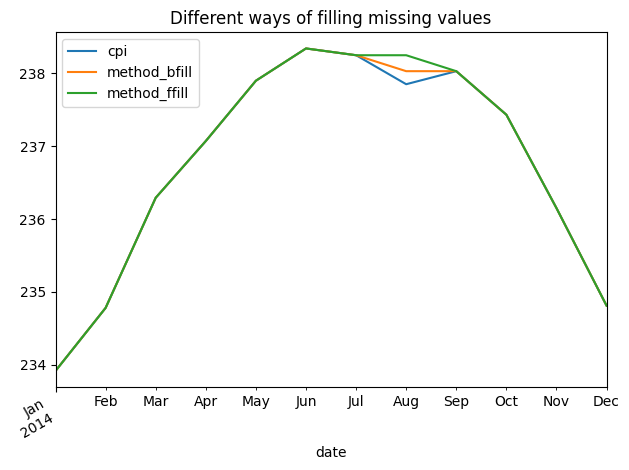

In [148]:
fig, ax = plt.subplots()
df.loc['2014-01-01':'2015-01-01'].drop(columns=['cpi_missing']).plot(title="Different ways of filling missing values", ax=ax)
fig.autofmt_xdate()
plt.tight_layout()

In [149]:
df['method_interpolate'] = df['cpi_missing'].interpolate()
# 使用线性插值

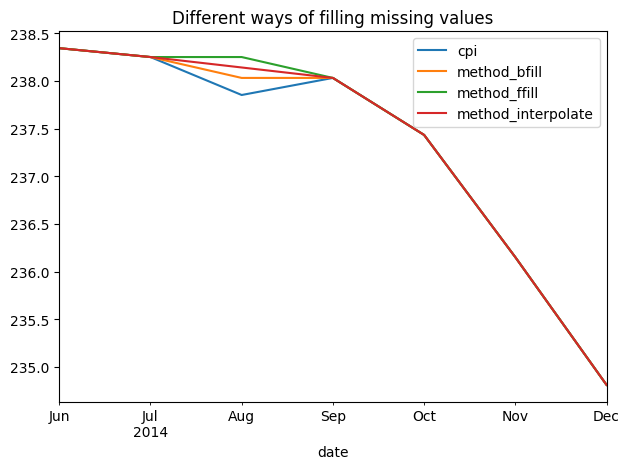

In [151]:
fig, ax = plt.subplots()
df.loc['2014-06-01':'2015-01-01'].drop(columns=['cpi_missing']).plot(title="Different ways of filling missing values", ax=ax)
fig.autofmt_xdate()
plt.tight_layout()

In [152]:
df.loc[rand_indices].sort_index()

,cpi,cpi_missing,method_bfill,method_ffill,method_interpolate
date,,,,,
2014-08-31,237.852,NaN,238.031,238.250,238.1405
2017-12-31,246.524,NaN,247.867,246.669,247.2680
2019-08-31,256.558,NaN,256.759,256.571,256.6650
2020-12-31,260.474,NaN,261.582,260.229,260.9055
2021-04-30,267.054,NaN,269.195,264.877,267.0360


## Converting currencies

In [1]:
from forex_python.converter import CurrencyRates
from utils.get_apple_data import get_aapl

In [6]:
df = get_aapl(start='2020-01-01', end='2020-01-31').drop(columns=['Adj Close', 'Volume'])

In [7]:
c = CurrencyRates()

In [8]:
df['usd_eur'] = [c.get_rate('USD', 'EUR', date) for date in df.index]

In [10]:
for column in df.columns[:-1]:
    df[f'{column}_EUR'] = df[column] * df['usd_eur']
df.head()

,Open,High,Low,Close,usd_eur,Open_EUR,High_EUR,Low_EUR,Close_EUR,usd_eur_EUR,Open_EUR_EUR,High_EUR_EUR,Low_EUR_EUR
Date,,,,,,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,0.893416,66.166352,67.140178,65.931833,67.084340,0.798191,59.114046,59.984078,58.904523
2020-01-03,74.287498,75.144997,74.125000,74.357498,0.897102,66.643490,67.412754,66.497712,66.706287,0.804793,59.786032,60.476140,59.655255
2020-01-06,73.447502,74.989998,73.187500,74.949997,0.893336,65.613277,66.991243,65.381008,66.955509,0.798049,58.614684,59.845670,58.407189
2020-01-07,74.959999,75.224998,74.370003,74.597504,0.895095,67.096311,67.333511,66.568209,66.771844,0.801195,60.057565,60.269881,59.584863
2020-01-08,74.290001,76.110001,74.290001,75.797501,0.899685,66.837608,68.475034,66.837608,68.193883,0.809433,60.132800,61.605969,60.132800


In [12]:
usd_rates = c.get_rates('USD')
usd_rates

{'EUR': 0.9372071227741331,
 'JPY': 151.7900656044986,
 'BGN': 1.8329896907216496,
 'CZK': 23.037488284910967,
 'DKK': 6.991377694470478,
 'GBP': 0.8168228678537958,
 'HUF': 353.514526710403,
 'PLN': 4.149953139643862,
 'RON': 4.658856607310216,
 'SEK': 10.880974695407685,
 'CHF': 0.904967197750703,
 'ISK': 143.67385192127463,
 'NOK': 11.131208997188379,
 'TRY': 28.588659793814436,
 'AUD': 1.5690721649484536,
 'BRL': 4.929615745079663,
 'CAD': 1.382755388940956,
 'CNY': 7.290909090909091,
 'HKD': 7.807778819119026,
 'IDR': 15700.000000000002,
 'INR': 83.26522961574508,
 'KRW': 1324.9484536082475,
 'MXN': 17.696344892221184,
 'MYR': 4.70796626054358,
 'NZD': 1.7002811621368323,
 'PHP': 56.08434864104967,
 'SGD': 1.3608247422680413,
 'THB': 35.99531396438613,
 'ZAR': 18.7464854732896}

## Different ways of aggregating trade data

In [2]:
from binance.spot import Spot as Client

In [3]:
spot_client = Client(base_url='https://api3.binance.com')
r = spot_client.trades('BTCEUR')

In [6]:
df = pd.DataFrame(r).drop(columns=["isBuyerMaker", "isBestMatch"])
df['time'] = pd.to_datetime(df['time'], unit='ms')

for column in ['price', 'qty', 'quoteQty']:
    # The qty column contains the traded amount of BTC
    # quoteQty contains the EUR price of the traded quantity, 
    # which is the same as multiplying the price column by the qty column.
    df[column] = pd.to_numeric(df[column])
df.head()


,id,price,qty,quoteQty,time
0,130151067,40690.11,0.00632,257.161495,2023-12-10 11:39:58.982
1,130151068,40690.10,0.00106,43.131506,2023-12-10 11:39:58.982
2,130151069,40699.12,0.00020,8.139824,2023-12-10 11:40:02.410
3,130151070,40701.23,0.00373,151.815588,2023-12-10 11:40:02.410
4,130151071,40690.55,0.00018,7.324299,2023-12-10 11:40:09.812


In [7]:
from utils.bars import get_bars

In [10]:
df_grouped_time = df.groupby(pd.Grouper(key='time', freq='1Min'))
time_bars = get_bars(df_grouped_time)
time_bars.head()

,open,high,low,close,vwap,vol,cnt
time,,,,,,,
2023-12-10 11:39:00,40690.11,40690.11,40690.10,40690.10,40690.108564,0.00738,2
2023-12-10 11:40:00,40699.12,40701.23,40671.50,40672.02,40686.010643,0.01741,13
2023-12-10 11:41:00,40671.51,40684.63,40671.51,40684.63,40679.629322,0.02875,12
2023-12-10 11:42:00,40680.10,40686.95,40674.24,40686.41,40684.802533,0.07996,26
2023-12-10 11:43:00,40678.81,40684.12,40671.50,40671.50,40681.007932,0.01765,11


In [16]:
bar_size = 50
df['tick_group'] = pd.Series(list(range(len(df)))).div(bar_size).apply(np.floor).astype(int).values

In [18]:
df_grouped_ticks = df.groupby('tick_group')
tick_bars = get_bars(df_grouped_ticks, add_time=True)
tick_bars

,time,open,high,low,close,vwap,vol,cnt
tick_group,,,,,,,,
0,2023-12-10 11:42:53.894,40690.11,40701.23,40671.50,40684.14,40684.212395,0.12956,50
1,2023-12-10 11:46:37.788,40677.25,40697.77,40665.59,40697.77,40674.922799,0.10884,50
2,2023-12-10 11:51:11.427,40698.17,40702.92,40666.28,40684.53,40693.055003,0.15008,50
3,2023-12-10 11:55:02.328,40684.53,40706.33,40684.53,40699.91,40700.642507,0.07228,50
4,2023-12-10 11:59:02.914,40701.11,40703.65,40690.44,40694.45,40698.510594,0.08328,50
5,2023-12-10 12:01:33.001,40694.45,40698.77,40681.70,40683.93,40694.033751,0.11768,50
6,2023-12-10 12:05:16.983,40683.95,40714.58,40683.95,40710.32,40701.287973,0.28800,50
7,2023-12-10 12:09:45.211,40710.32,40723.99,40699.25,40716.71,40708.980885,0.12211,50
8,2023-12-10 12:14:20.927,40717.10,40724.15,40707.23,40711.51,40713.722895,0.13978,50


In [19]:
bar_size = 1
df['cum_qty'] = df['qty'].cumsum()
df['vol_group'] = df['cum_qty'].div(bar_size).apply(np.floor).astype(int).values

In [22]:
df_grouped_ticks = df.groupby('vol_group')
volume_bars = get_bars(df_grouped_ticks, add_time=True)
volume_bars

,time,open,high,low,close,vwap,vol,cnt
vol_group,,,,,,,,
0,2023-12-10 12:08:00.752,40690.11,40714.58,40665.59,40706.64,40694.036737,0.99911,380
1,2023-12-10 12:18:08.416,40706.65,40735.72,40701.93,40733.34,40713.813007,0.33397,120


,id,price,qty,quoteQty,time,tick_group,cum_qty,vol_group
0,130151067,40690.11,0.00632,257.161495,2023-12-10 11:39:58.982,0,0.00632,0
1,130151068,40690.10,0.00106,43.131506,2023-12-10 11:39:58.982,0,0.00738,0
2,130151069,40699.12,0.00020,8.139824,2023-12-10 11:40:02.410,0,0.00758,0
3,130151070,40701.23,0.00373,151.815588,2023-12-10 11:40:02.410,0,0.01131,0
4,130151071,40690.55,0.00018,7.324299,2023-12-10 11:40:09.812,0,0.01149,0
...,...,...,...,...,...,...,...,...
375,130151442,40699.25,0.00002,0.813985,2023-12-10 12:07:39.683,7,0.97704,0
376,130151443,40703.25,0.00302,122.923815,2023-12-10 12:07:41.692,7,0.98006,0
377,130151444,40706.65,0.00238,96.881827,2023-12-10 12:07:57.313,7,0.98244,0
378,130151445,40706.62,0.00609,247.903316,2023-12-10 12:08:00.752,7,0.98853,0


In [26]:
bar_size = 50_000
df['cum_value'] = df['quoteQty'].cumsum()
df['value_group'] = df['cum_value'].div(bar_size).apply(np.floor).astype(int).values
df_grouped_ticks = df.groupby('value_group')
dollar_bars = get_bars(df_grouped_ticks, add_time=True)
dollar_bars

,time,open,high,low,close,vwap,vol,cnt
value_group,,,,,,,,
0,2023-12-10 12:14:37.221,40690.11,40724.15,40665.59,40711.74,40697.539391,1.22776,456
1,2023-12-10 12:18:08.416,40711.72,40735.72,40707.74,40733.34,40715.915413,0.10532,44
